# Height Data

In [1]:
using Distributions
using StatisticalRethinking
using DataFrames
using CSV
using ForwardDiff

include("lahmc.jl")
include("run_lahmc.jl")

sample_loop (generic function with 1 method)

In [2]:
howell = CSV.read(sr_datadir("Howell1.csv"), DataFrame)
howell = howell[howell.age .>= 18,:]
howell = sort(howell, :weight)
first(howell, 5)

Row,height,weight,age,male
,Float64,Float64,Float64,Int64
1,143.51,31.0711,18.0,0
2,141.605,31.5246,19.0,1
3,142.24,31.6664,36.0,0
4,136.525,31.8648,65.0,0
5,146.05,31.8648,44.0,0


In [3]:
describe(howell, :all)
# size(howell)

Row,variable,mean,std,min,q25,median,q75,max,sum,nunique,nuniqueall,nmissing,nnonmissing,first,last,eltype
,Symbol,Float64,Float64,Real,Float64,Float64,Float64,Real,Real,Nothing,Int64,Int64,Int64,Real,Real,DataType
1,height,154.597,7.74233,136.525,148.59,154.305,160.655,179.07,54418.2,,81,0,352,143.51,163.83,Float64
2,weight,44.9905,6.45671,31.0711,40.2563,44.7922,49.2927,62.9926,15836.7,,289,0,352,31.0711,62.9926,Float64
3,age,41.1385,15.9679,18.0,28.0,39.0,51.0,88.0,14480.8,,77,0,352,18.0,35.0,Float64
4,male,0.46875,0.499733,0,0.0,0.0,1.0,1,165,,2,0,352,0,1,Int64


In [4]:
xbar = mean(howell.weight)
n = nrow(howell)

function U(X)
    a = X[1]
    b = X[2]
    sigma = X[3]
    return -(sum(logpdf(Normal((a + b*(howell[i, :].weight - xbar)), sigma), 
        howell[i, :].height) for i in 1:n) 
        + logpdf(Normal(178, 20), a) + logpdf(LogNormal(0,1), b) + logpdf(Uniform(0, 50), sigma))  
end

# function dU(X)
#     a = X[1]
#     b = X[2]
#     sigma = X[3]
#     da = -(a - 178)/(20^2) + sum(howell[i, :].height - 
#         (a + b*(howell[i, :].weight - xbar))/(sigma^2) for i in 1:n)

#     db = -(b)/(10^2) + sum((howell[i, :].weight - xbar)*(howell[i, :].height 
#             - (a + b*(howell[i, :].weight - xbar)))/(sigma^2) for i in 1:n)

#     dsigma = -(n+1)/(sigma) + sum(((howell[i, :].height 
#         - (a + b*(howell[i, :].weight - xbar)))^2)/(sigma^3) for i in 1:n)
    
#     return [-da, -db, -dsigma]
# end

function dU(X)
    return ForwardDiff.gradient(U, [X[1], X[2], X[3]])
end

function init_q()
    init_sample = [155, 0.5, 25]
    accepted_sample = burn_in!(LAHMC(U, dU, init_sample, epsilon, L, 1, beta, n_samples))
    return accepted_sample
end

# return -(sum([logpdf(Normal((a + b*(howell[i, :].weight - xbar)), sigma), 
    #     howell[i, :].height) for i in 1:1]) 
    #     + logpdf(Normal(178, 20), a) + logpdf(Normal(0,10), b) + logpdf(Uniform(0, 50), sigma))

# LogNormal beta
    # db = -(2*X[2])/(log(1/(10*sqrt(2*pi)))-X[2]^2) + sum([(howell[i, :].weight - xbar)*(howell[i, :].height 
    #     - (X[1] + X[2]*(howell[i, :].weight - xbar)))/(X[3]^2) for i in 1:n])

# da = -(a - 178)/(20^2) + sum([howell[i, :].height - 
    #     (a + b*(howell[i, :].weight - xbar))/(sigma^2) for i in 1:1])

    # db = -(b)/(10^2) + sum([(howell[i, :].weight - xbar)*(howell[i, :].height 
    #         - (a + b*(howell[i, :].weight - xbar)))/(sigma^2) for i in 1:1])

    # # LogNormal beta
    # # db = -(2*X[2])/(log(1/(10*sqrt(2*pi)))-X[2]^2) + sum([(howell[i, :].weight - xbar)*(howell[i, :].height 
    # #     - (X[1] + X[2]*(howell[i, :].weight - xbar)))/(X[3]^2) for i in 1:1])

    # dsigma = -(n+1)/sigma + sum([((howell[i, :].height 
    #     - (a + b*(howell[i, :].weight - xbar)))^2)/(sigma^3) for i in 1:1])

init_q (generic function with 1 method)

In [5]:
n_samples = 1000
n_chains = 1
epsilon = 0.01
L = 10
beta = 1
n_param = 3

lahmc_samples, grad_count = sample_loop(n_chains, U, dU, init_q, epsilon, L, 4, beta, n_param, n_samples)

Accepted sample found after 5 iterations.
Average acceptance rate: 1.0
Average transition rates: L1: 0.994994994994995 L2: 0.002002002002002002 L3: 0.003003003003003003 L4: 0.0 F: 0.0


([154.80053722302782; 0.7594558739270533; 24.76831734198222;;; 154.74321567155917; 0.8524415654261399; 24.747123233636636;;; 154.76389144470107; 0.9656766383504839; 24.7128642747393;;; … ;;; 154.82314930805956; 0.8523324082184078; 5.199410410212492;;; 154.93167958076847; 0.9196565714268291; 5.1470973077208555;;; 154.89416032235764; 0.8270531522691251; 5.237082206697772], 10070)

In [6]:
hmc_samples, grad_count = sample_loop(n_chains, U, dU, init_q, epsilon, L, 1, beta, n_param, n_samples)


Accepted sample found after 5 iterations.
Average acceptance rate: 0.998998998998999
Average transition rates: L1: 0.998998998998999 F: 0.001001001001001001


([155.3473601341987; 0.7637366963744475; 24.961333142806257;;; 155.51084067815225; 0.6600954340969066; 24.7770635631466;;; 155.50729286694116; 0.7195614330167907; 24.75472272726902;;; … ;;; 154.4463843882815; 0.927885453573093; 5.082123274329386;;; 154.4170172516594; 0.891435719708688; 5.061308665993626;;; 154.3076164842313; 0.91734962643806; 5.184105965678513], 9990)

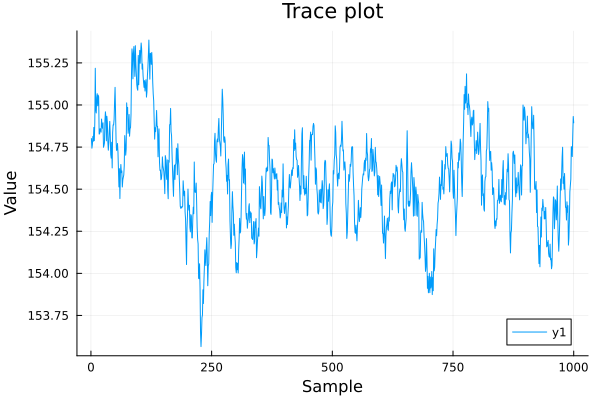

In [7]:
plot(lahmc_samples[1, 1, :], title="Trace plot", xlabel="Sample", ylabel="Value")

In [8]:
# autocorrelation_lahmc = calculate_looped_autocorrelation(lahmc_samples)
# autocorrelation_hmc = calculate_looped_autocorrelation(hmc_samples)

# gradient_evaluations_lahmc = LinRange(0, grad_count/n_chains, length(autocorrelation_lahmc))
# gradient_evaluations_hmc = LinRange(0, grad_count/n_chains, length(autocorrelation_hmc))

# plt_lahmc_ac = plot(gradient_evaluations_lahmc, autocorrelation_lahmc, title="Gradient Evaluations vs Autocorrelation", xlabel="Gradient Evaluations", ylabel="Autocorrelation", label="LAHMC")
# plt_hmc_ac = plot!(gradient_evaluations_hmc, autocorrelation_hmc, label="HMC")

# display(plt_lahmc_ac)

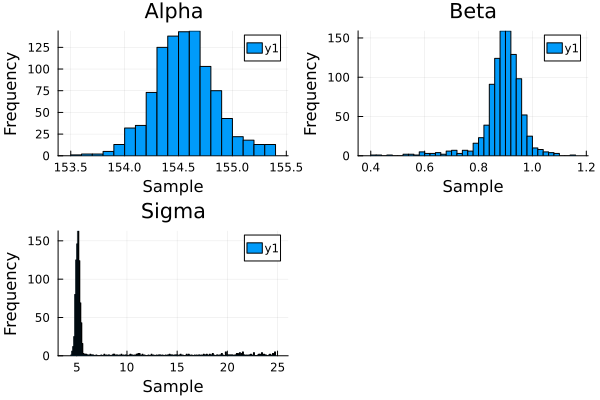

In [9]:
plot(
    histogram(lahmc_samples[1, 1, :], bin_width=0.01, title="Alpha", xlabel="Sample", ylabel="Frequency"),
    histogram(lahmc_samples[2, 1, :], bin_width=0.2, title="Beta", xlabel="Sample", ylabel="Frequency"),
    histogram(lahmc_samples[3, 1, :], bin_width=0.2, title="Sigma", xlabel="Sample", ylabel="Frequency"),
)

In [10]:
df_post = DataFrame(lahmc_samples[:, 1, :]', :auto)
rename!(df_post,[:a, :b, :sigma])
first(df_post, 5)

Row,a,b,sigma
,Float64,Float64,Float64
1,154.801,0.759456,24.7683
2,154.743,0.852442,24.7471
3,154.764,0.965677,24.7129
4,154.813,0.886646,24.7939
5,154.785,0.915824,24.7679


In [11]:
describe(df_post)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,a,154.56,153.565,154.557,155.386,0,Float64
2,b,0.891637,0.415393,0.898962,1.14465,0,Float64
3,sigma,7.25167,4.49018,5.16353,24.7939,0,Float64


In [12]:
round.(cov(lahmc_samples[:, 1, :]'), digits=3)

3×3 Matrix{Float64}:
  0.083  -0.006   0.733
 -0.006   0.006  -0.16
  0.733  -0.16   26.251

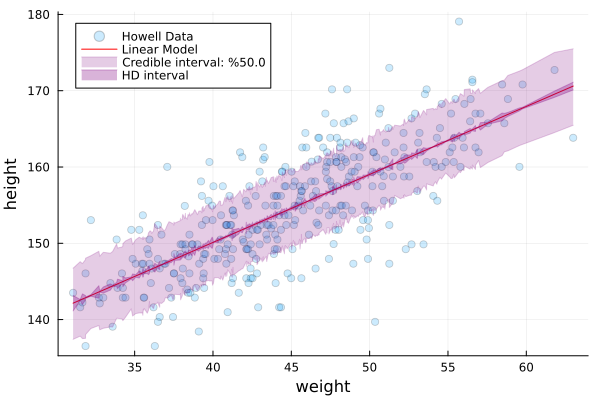

In [13]:
a_mean = mean(lahmc_samples[1, 1, :])
b_mean = mean(lahmc_samples[2, 1, :])
sigma_mean = mean(lahmc_samples[3, 1, :])

pred = [a_mean + b_mean*(x-xbar) for x in howell.weight]

q_alpha = 0.5
quantiles = [quantile(rand(Normal(v, sigma_mean), 1000), [0.5 - q_alpha/2, 0.5 + q_alpha/2]) for v in pred]
q_lower = [q[1] for (q, pred) in zip(quantiles, pred)]
q_upper = [q[2] for (q, pred) in zip(quantiles, pred)]

hdi = [quantile(rand(Normal(v, sigma_mean), 1000), 0.5) for v in pred]
hdi_lower = [min(q[1], pred - (q[1] - pred)) for (q, pred) in zip(hdi, pred)]
hdi_upper = [max(q[1], pred + (pred - q[1])) for (q, pred) in zip(hdi, pred)]

scatter(howell.weight, howell.height; alpha=0.2, xlabel="weight", ylabel="height", label="Howell Data")
plot!(howell.weight, pred, color=:red, alpha=1, label="Linear Model")
plot!(howell.weight, q_lower, color=:purple, alpha=0.2, label=nothing)
plot!(howell.weight, q_upper, fill=q_lower, alpha=0.2, color=:purple, label="Credible interval: %$(q_alpha*100)")
plot!(howell.weight, hdi_lower, color=:purple, alpha=0.3, label=nothing)
plot!(howell.weight, hdi_upper, fill=hdi_lower, alpha=0.3, color=:purple, label="HD interval")